## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
##  Camera calibration using chessboard images

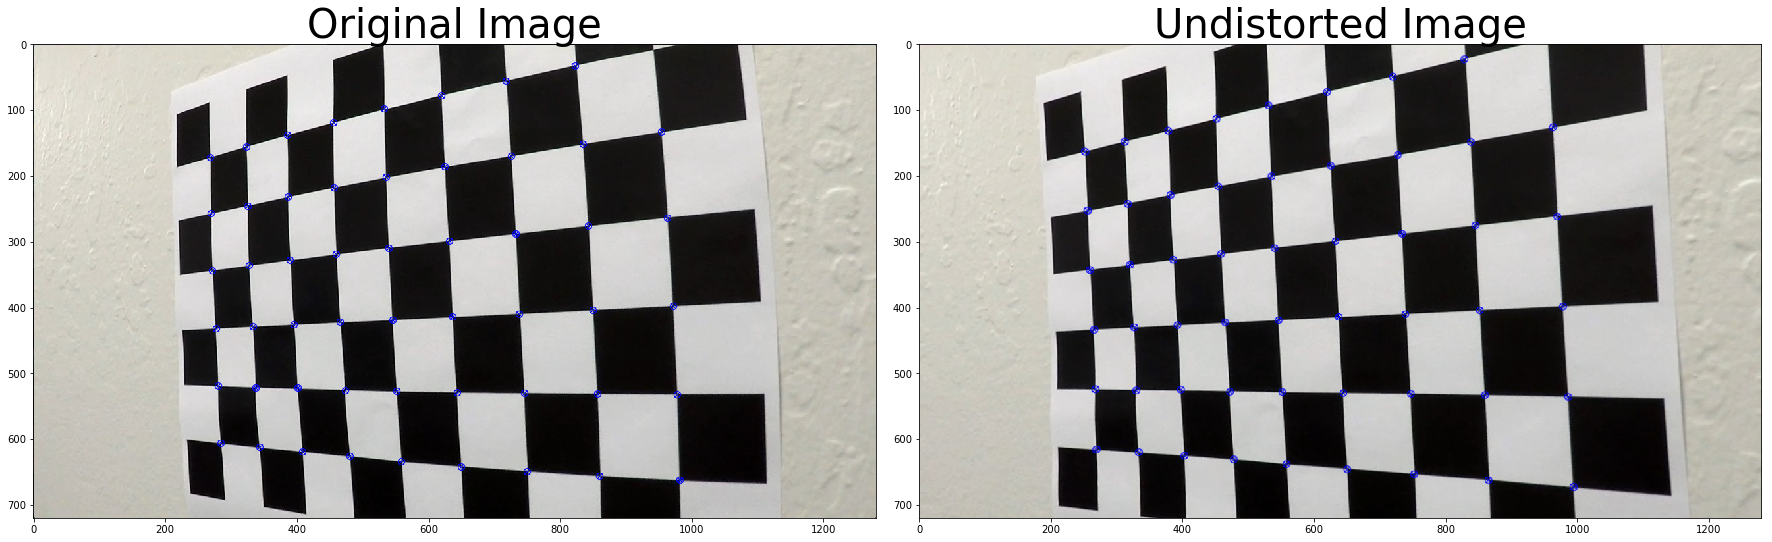

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        undist, mtx, dist = cal_undistort(img, objpoints, imgpoints)

image = mpimg.imread('../camera_cal/calibration4.jpg')
undist, mtx, dist = cal_undistort(image, objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("chess")

## Distortion Correction & Transform

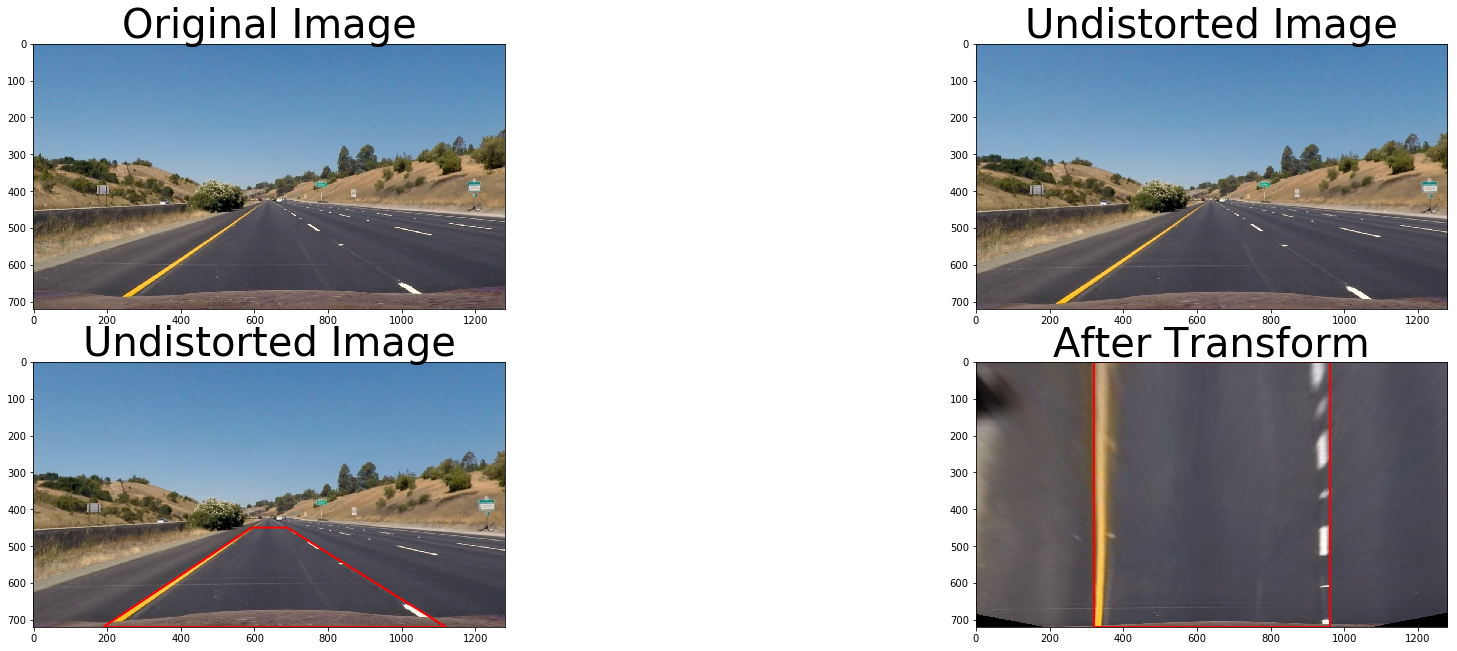

In [2]:
import matplotlib.patches as patches

def birdseye_transform(img):
    img_size = (img.shape[1], img.shape[0])
    
    src_tl = [593, 450]      # top left
    src_tr = [689, 450]      # top right
    src_br = [1120, 720]     # bottom right
    src_bl = [190, 720]      # bottom left
    
    src = np.float32([src_tl, src_tr, src_br, src_bl])
    
    
    dst_tl = [320, 0]      # top left
    dst_tr = [960, 0]      # top right
    dst_br = [960, 720]     # bottom right
    dst_bl = [320, 720]      # bottom left
    
    dst = np.float32([dst_tl, dst_tr, dst_br, dst_bl])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

image = mpimg.imread('../test_images/straight_lines1.jpg')
# image = mpimg.imread('../test_images/test5.jpg')
undist, mtx, dist = cal_undistort(image, objpoints, imgpoints)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 9))
# f.tight_layout()

ax1.imshow(image)
ax1.set_title("Original Image", fontsize=40)

ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=40)

ax3.imshow(undist)
ax3.set_title('Undistorted Image', fontsize=40)
ax3.add_patch(
    patches.Polygon(
    ([593, 450], [689, 450], [1120, 720], [190, 720]),
    color="r",
    fill=False,
    linestyle="-",
    linewidth=2
    )
)


ax4.imshow(birdseye_transform(undist)[0])
ax4.set_title('After Transform', fontsize=40)
ax4.add_patch(
    patches.Polygon(
    ([320, 0], [960, 0], [960, 720], [320, 720]),
    color="r",
    fill=False,
    linestyle="-",
    linewidth=2
    )
)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("transform")

## Gradient and Colour Thresholding

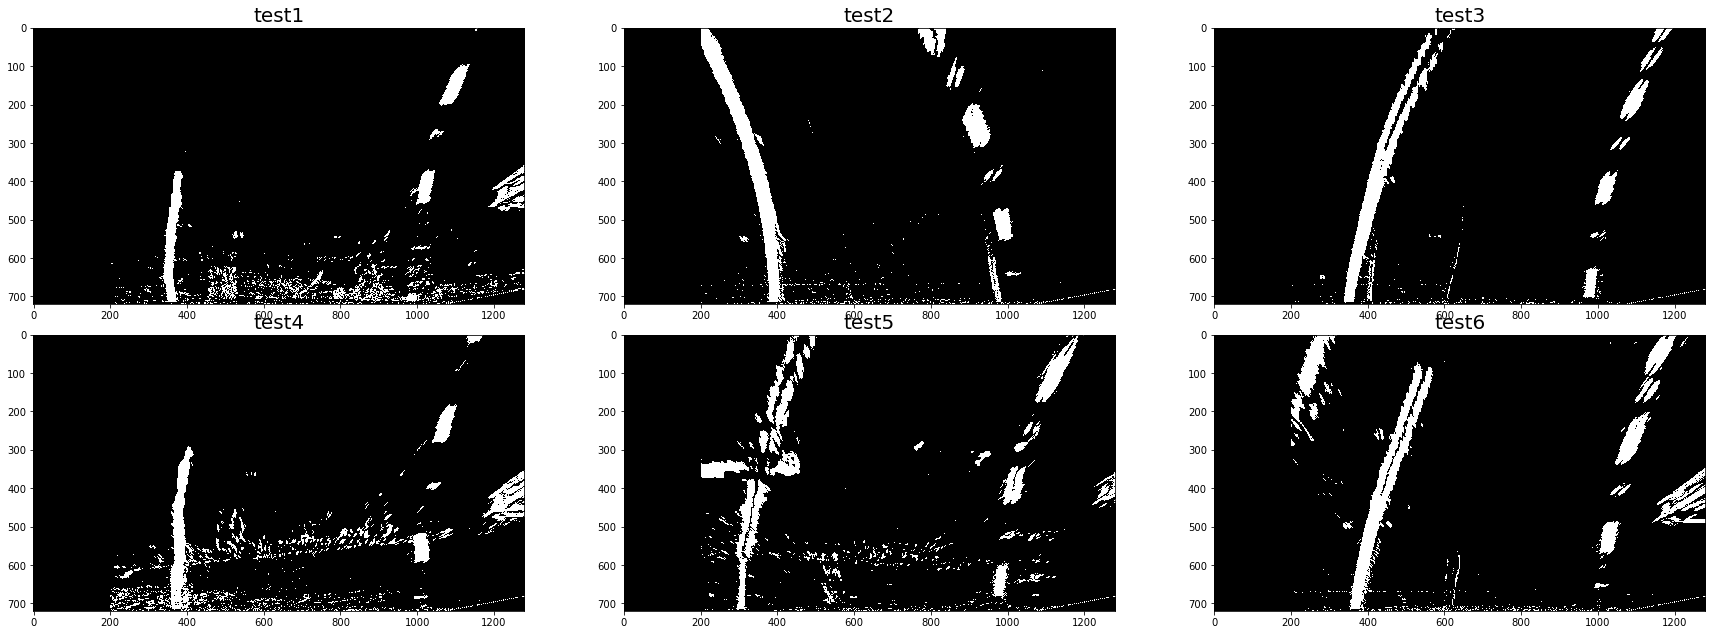

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag) // 255
    gradmag = (gradmag//scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return dir_binary

def binary_thresh(img_channel, thresh=(0, 255)):
    binary = np.zeros_like(img_channel)
    binary[(img_channel >= thresh[0]) & (img_channel <= thresh[1])] = 1
    
    return binary


# Edit this function to create your own pipeline.
def preprocess(img):
    img = np.copy(img)
    # Convert to HLS color space and separate channels
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    
    # Choose a Sobel kernel size
    ksize = 9 # Choose a larger odd number to smooth gradient measurements
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    
    # Threshold color channel
    s_binary = binary_thresh(s_channel, thresh=(170, 255))
    l_binary = binary_thresh(l_channel, thresh=(210, 255))
    
    # Stack each channel
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(gradx == 1) | (s_binary == 1) | (l_binary == 1)] = 1
    combined_binary[:, :200] = 0
    
    return combined_binary

images = glob.glob('../test_images/test*.jpg')
display = []
for fname in images:
    image = mpimg.imread(fname)
    undist, mtx, dist = cal_undistort(image, objpoints, imgpoints)
    result = preprocess(birdseye_transform(undist)[0])
    display.append(result)

# Plot the result
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(display[0], cmap="gray")
ax1.set_title('test1', fontsize=20)

ax2.imshow(display[1], cmap="gray")
ax2.set_title('test2', fontsize=20)

ax3.imshow(display[2], cmap="gray")
ax3.set_title('test3', fontsize=20)

ax4.imshow(display[3], cmap="gray")
ax4.set_title('test4', fontsize=20)

ax5.imshow(display[4], cmap="gray")
ax5.set_title('test5', fontsize=20)

ax6.imshow(display[5], cmap="gray")
ax6.set_title('test6', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("thresholding")

## Finding Lines

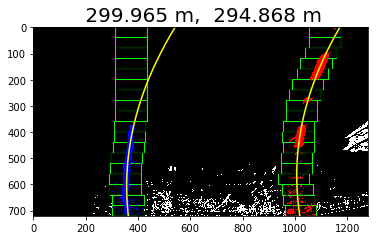

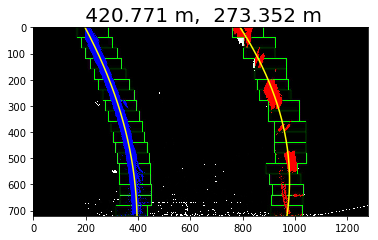

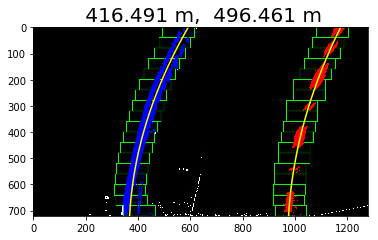

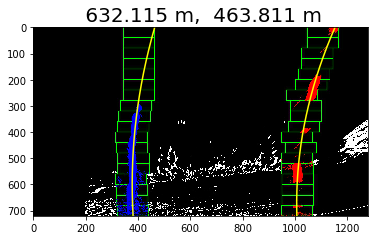

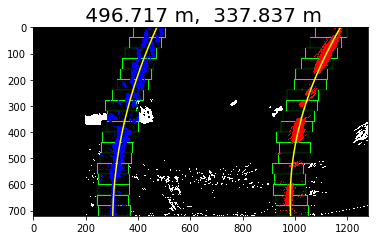

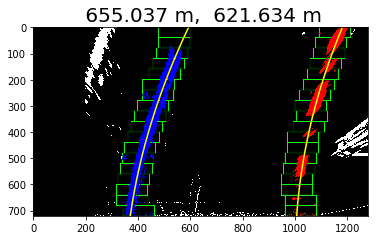

In [4]:
def find_lines(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 18
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 60
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/640 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img, left_fit, right_fit, ploty, (left_curverad, right_curverad)


images = glob.glob('../test_images/test*.jpg')
for i, fname in enumerate(images):
    image = mpimg.imread(fname)
    undist, mtx, dist = cal_undistort(image, objpoints, imgpoints)
    result = preprocess(birdseye_transform(undist)[0])
    output, left_fit, right_fit, ploty, curvature = find_lines(result)
    
    # Plot the lines and save to an image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Due to Python Qt problem, I am using OpenCV to save the image with windows first
    cv2.imwrite("out{}.jpg".format(i), output)
    out_img = mpimg.imread("out{}.jpg".format(i))
    title = "{0: .3f} m, {1: .3f} m".format(curvature[0], curvature[1])
    plt.figure()
    plt.imshow(out_img)
    plt.title(title, fontsize=20)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.savefig("out{}.jpg".format(i))
    
    

## Pipeline

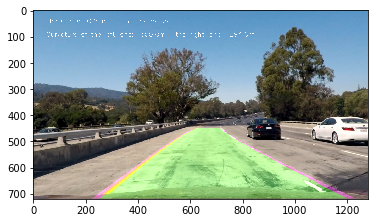

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

right_lane = []
left_lane = []
n = 5

def calc_car_offset(left_point, right_point, center):
    xm_per_pix = 3.7/640
    lane_center = (left_point + right_point) / 2
    return (center - lane_center) * xm_per_pix

def calc_avg_fit(xfit, n):
    m = len(xfit)
    temp = np.zeros_like(xfit[0])
    if m < n:
        for fit in xfit:
            temp += fit
            
        return temp / m
            
    else:
        for fit in xfit[m-n:]:
            temp += fit
            
        return temp / n
        
        
def pipeline(frame):
    
    image = np.copy(frame)
    
    # Undistort the image
    undist, mtx, dist = cal_undistort(image, objpoints, imgpoints)
    
    # Pre-Process the undistorted image
    warped, M, Minv = birdseye_transform(undist)
    warped_binary = preprocess(warped)
    
    # Detect the lines
    output, left_fit, right_fit, ploty, curvature = find_lines(warped_binary)
    
    # Find the curve
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # If the newly detected lane is too far from previous one, abandon it
    if left_lane and right_lane:
        prev_left = left_lane[-1][0]*ploty**2 + left_lane[-1][1]*ploty + left_lane[-1][2]
        prev_right = right_lane[-1][0]*ploty**2 + right_lane[-1][1]*ploty + right_lane[-1][2]
    
        if abs(left_fitx[719] - prev_left[719]) < 50:
            # Append the fitted lines to variables for later use
            left_lane.append(left_fit)

        if abs(right_fitx[719] - prev_right[719]) < 50:
            # Append the fitted lines to variables for later use
            right_lane.append(right_fit)
            
    else:
        left_lane.append(left_fit)
        right_lane.append(right_fit)
        
    # Use average to smooth the lane
    left_fit_avg = calc_avg_fit(left_lane, n)
    right_fit_avg = calc_avg_fit(right_lane, n)
    # Find the curve using the average
    left_fitx = left_fit_avg[0]*ploty**2 + left_fit_avg[1]*ploty + left_fit_avg[2]
    right_fitx = right_fit_avg[0]*ploty**2 + right_fit_avg[1]*ploty + right_fit_avg[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, ploty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(255,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Diplay curvature and the car position
    offset = abs(calc_car_offset(left_fitx[719], right_fitx[719], 640))
    direction = "left" if offset > 0 else "right"
    curvature_text = "Curvature of the left lane: {0: .1f}m   the right lane: {1: .1f}m".format(curvature[0], curvature[1])
    car_pos_text = "The Car is {0: .2f}m {1} of the center.".format(offset, direction)
    cv2.putText(result, car_pos_text, (50, 50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(255, 255, 255))
    cv2.putText(result, curvature_text, (50, 100), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(255, 255, 255))
    
    return result

image = mpimg.imread('../test_images/test1.jpg')
out = pipeline(image)
plt.imshow(out)
plt.imsave("final_out.jpg", out)

In [6]:
from moviepy.editor import VideoFileClip

right_lane = []
left_lane = []
n = 10
output = "output.mp4"
clip1 = VideoFileClip("project_video.mp4")
out_clip = clip1.fl_image(pipeline)
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [22:34<00:01,  1.09s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Wall time: 22min 35s
